In [34]:
using AlgebraicDynamics
using AlgebraicDynamics.Hypergraphs

using Base.Iterators
using Test
using LinearAlgebra
using Catlab
using Catlab.Programs.RelationalPrograms
using Catlab.CategoricalAlgebra
using Catlab.CategoricalAlgebra.CSets
using Catlab.WiringDiagrams

using OrdinaryDiffEq
using Plots

# Demonstration of 2D composition of Diffusive Systems
This notebook will describe the process of generating larger physical systems from smaller, more basic systems using the AlgebraicDynamics library.

## Definition of Generators

In [2]:
Δt = 0.01
Δx = 0.1
δ  = 1

generators = Dict(
    #      u2
    #       |
    #u3 -  u5 - u1
    #       |
    #      u3
    :laplace_bulk   => (u, p, t) -> [(u[5]-u[1])*δ*Δt/(Δx^2),
                                     (u[5]-u[2])*δ*Δt/(Δx^2),
                                     (u[5]-u[3])*δ*Δt/(Δx^2),
                                     (u[5]-u[4])*δ*Δt/(Δx^2),
                                     (u[1] + u[2] + u[3] + u[4] - 4*u[5])*δ*Δt/(Δx^2)],
    #      u2
    #       |
    #u3 -  u4 - u1
    :laplace_edge   => (u, p, t) -> [(u[4]-u[1])*δ*Δt/(Δx^2),
                                     (u[4]-u[2])*δ*Δt/(Δx^2),
                                     (u[4]-u[3])*δ*Δt/(Δx^2),
                                     (u[1] + u[2] + u[3] - 3*u[4])*δ*Δt/(Δx^2)],
    # u2
    # |
    # u3 - u1
    :laplace_corner => (u, p, t) -> [(u[3]-u[1])*δ*Δt/(Δx^2),
                                     (u[3]-u[2])*δ*Δt/(Δx^2),
                                     (u[1] + u[2] - 2*u[3])*δ*Δt/(Δx^2)]
);



## Generating an open square

In [3]:
#  x1  x5  x2  x6      x1-x2-
#  x7      x8          |  |
#  x4  x9  x5 x10      x3-x4-
#  x11    x12          |  |

square = @relation (x6,x10,x11,x12) where ( x1::X, x2::X,
                                            x3::X, x4::X,
                                            x5::X, x6::X,
                                            x7::X, x8::X,
                                            x9::X,x10::X,
                                           x11::X,x12::X) begin
    laplace_corner(x5,x7,x1)
    laplace_edge(x6,x5,x8,x2)
    laplace_edge(x9,x7,x11,x3)
    laplace_bulk(x10,x8,x9,x12,x4)
end;

## Solving the dynamics on the square

In [25]:
f = vectorfield(square,generators)
u₀ = [ 0, 0,
       0,10,
       0, 0, 0, 0,
       0, 0, 0, 0]

p = ODEProblem(f, u₀, (0,10.0), zeros(length(u₀)))
sol = OrdinaryDiffEq.solve(p, Trapezoid());
#@test norm(sol.u[end] - u₀) < 1e-4

In [51]:
label=[string(sol.t[i])[1:3] for i in 1:length(sol.u)];

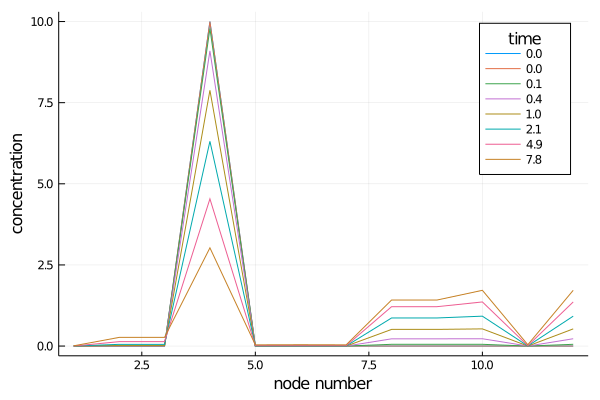

In [46]:
plot(sol.u[1:4:32], label=hcat(label[1:4:32]...), legendtitle="time", xlabel="node number", ylabel="concentration")

┌ Info: Saved animation to 
│   fn = /Users/abaas3/Documents/work/gat_em/AlgebraicDynamics/notebooks/tmp.gif
└ @ Plots /Users/abaas3/.julia/packages/Plots/6RLiv/src/animation.jl:104


Plots.AnimatedGif("/Users/abaas3/Documents/work/gat_em/AlgebraicDynamics/notebooks/tmp.gif")
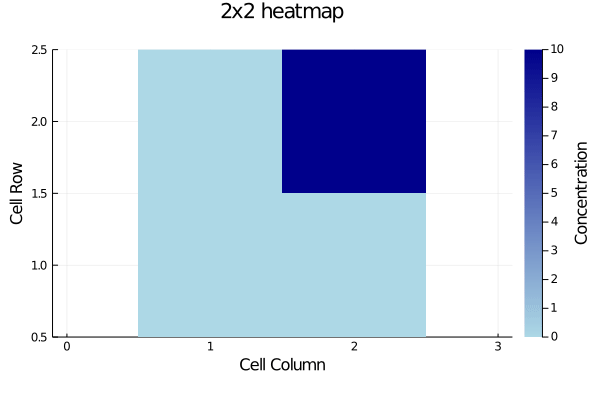

In [35]:
x = 1:2
y = 1:2
timestep = 0.01
solution = sol(0:timestep:2)
anim = @animate for i ∈ 1:length(solution)
    c_func(x::Int, y::Int) = solution[i][(y-1)*2+x]
    heatmap(x,y,c_func, title="2x2 heatmap", aspect_ratio=1, clims=(0,maximum(solution[1])), fill=true, color=:blues, xaxis="Cell Column", yaxis="Cell Row", colorbartitle="Concentration")
end
gif(anim, fps = 60)

## Compose open squares together

In [36]:
#     - N1 -
#     - N2 -
# |  |      |  |
# E1 E2    W2 W1
# |  |      |  |
#     - S2 -
#     - S1 -

comp_2x2 = @relation () where (N1::X,N2::X,S1::X,S2::X,E1::X,E2::X,W1::X,W2::X) begin
    square(N1,N2,E1,E2)
    # horizontal mirror of square1
    square(N1,N2,W1,W2)
    # vertical mirror of square1
    square(S1,S2,E1,E2)
    # double mirror of square1
    square(S1,S2,W1,W2)
end
square_4x4 = ocompose(comp_2x2,[square, square, square, square]);

## Solve the new system

In [47]:

f = vectorfield(square_4x4,generators)

u₀ = [ 0, 0, 0, 0,
       0, 0, 0, 0,
       0, 1,
       0, 1,
       0, 0, 0, 0,
       0, 0,
       0, 0,
       0, 0, 0, 0,
       0, 0,
       0, 0,
       0, 0, 0, 0,
       0, 0,
       0, 0,
       0, 0, 0, 0]

p = ODEProblem(f, u₀, (0,10.0), zeros(48))

sol = OrdinaryDiffEq.solve(p, Trapezoid());

In [48]:
function get_index(x,y)
    offset = 8
    if x > 2 && y <= 2
        offset = 16
        x = 5-x
    elseif y > 2 && x <= 2
        offset = 24
        y = 5-y
    elseif y > 2 && x > 2
        offset = 32
        y = 5-y
        x = 5-x
    end
    index = offset + (y-1)*2+x
end

get_index (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /Users/abaas3/Documents/work/gat_em/AlgebraicDynamics/notebooks/tmp.gif
└ @ Plots /Users/abaas3/.julia/packages/Plots/6RLiv/src/animation.jl:104


Plots.AnimatedGif("/Users/abaas3/Documents/work/gat_em/AlgebraicDynamics/notebooks/tmp.gif")
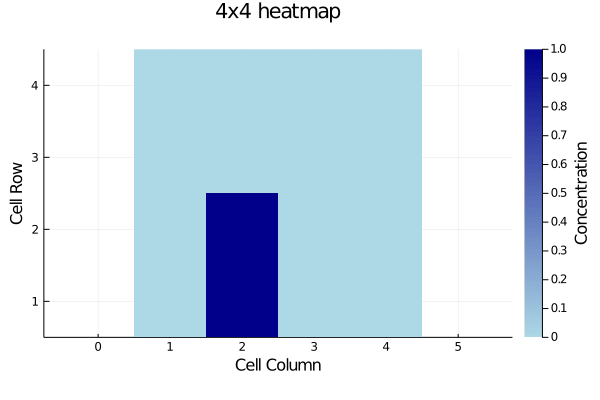

In [49]:
x = 1:4
y = 1:4
timestep = 0.1
solution = sol(0:timestep:5)
anim = @animate for i ∈ 1:length(solution)
    c_func(x::Int, y::Int) = solution[i][get_index(x,y)]
    heatmap(x,y,c_func, title="4x4 heatmap", aspect_ratio=1,clims=(0,maximum(solution[1])), fill=true, color=:blues, xaxis="Cell Column", yaxis="Cell Row", colorbartitle="Concentration")
end
gif(anim, fps = 10)